# Image Processing SoSe 22 - Assignment - 04

### Deadline is 19.05.2022 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.

In [35]:
# display the plots inside the notebook
%matplotlib inline

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
import random
from io import BytesIO
from PIL import Image
from skimage.color import rgb2gray

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [41]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(
        np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff'))
    )
for name in ['house']:
    sample_images.append(
        np.array(Image.open(direc+name+'.tiff'))
    )

<BarContainer object of 5 artists>

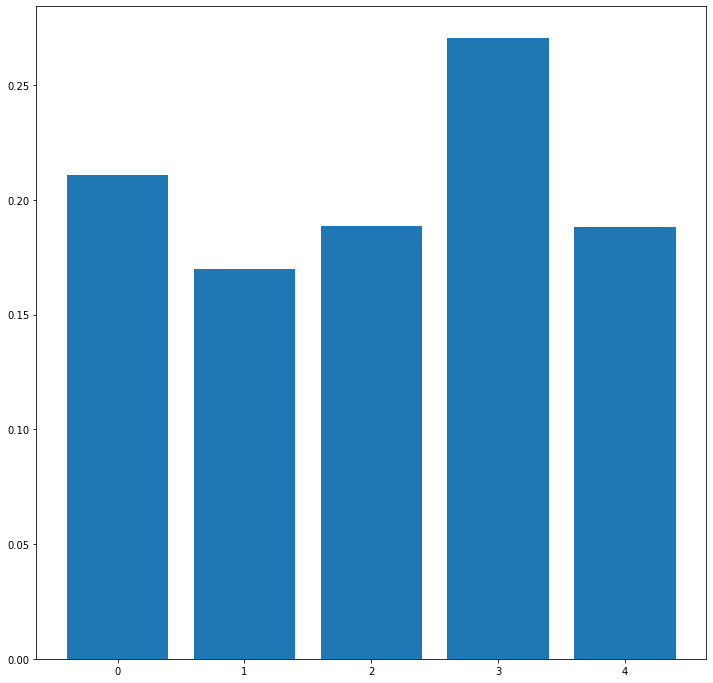

In [42]:
def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is constant in the images.
    """
    if len(img.shape) == 3:
        img = rgb2gray(img)
    pixelcounter = img.shape[0]*img.shape[1]
    pixelsum = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixelsum = pixelsum + img[x][y]
    pixelaverage = pixelsum / pixelcounter
    std = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            std = std + ((img[x][y]-pixelaverage)**2)
    noise = math.sqrt(std/pixelcounter)
    return noise

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])

<BarContainer object of 5 artists>

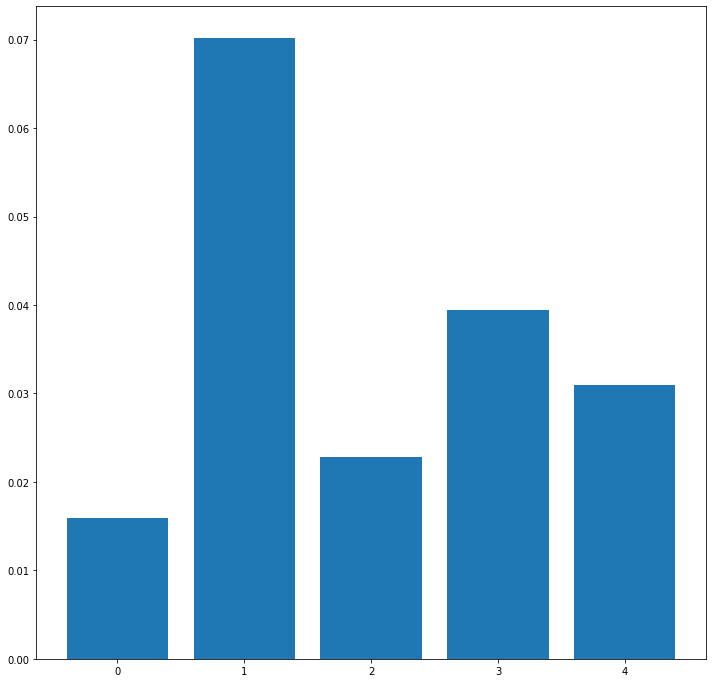

In [44]:
def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    if len(img.shape) == 3:
        img = rgb2gray(img)
    diffcounter = img.shape[0]*img.shape[1]
    diffsum = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            """
            We calculate the pixel average based on the difference to all adjacent pixels (not diagonally)
            First,handle all edge-cases: x,y = 0 or max"""
            if x==0 and y==0:
                diffsum = diffsum + (abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y+1]))/2
            elif x==0 and y!=img.shape[1]-1:
                diffsum = diffsum + (abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y+1])+abs(img[x][y]-img[x][y-1]))/3
            elif x==0:
                diffsum = diffsum + (abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y-1]))/2
            elif y==0 and x!=img.shape[0]-1:
                diffsum = diffsum + (abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y+1])+abs(img[x][y]-img[x-1][y]))/3
            elif y==0:
                diffsum = diffsum + (abs(img[x][y]-img[x][y+1])+abs(img[x][y]-img[x-1][y]))/2
            elif x==img.shape[0]-1 and y!=img.shape[1]-1:
                diffsum = diffsum + (abs(img[x][y]-img[x-1][y])+abs(img[x][y]-img[x][y+1])+abs(img[x][y]-img[x][y-1]))/3
            elif x==img.shape[0]-1:
                diffsum = diffsum + (abs(img[x][y]-img[x][y-1])+abs(img[x][y]-img[x-1][y]))/2
            elif y==img.shape[1]-1:
                diffsum = diffsum + (abs(img[x][y]-img[x-1][y])+abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y-1]))/3
            else: #all pixels not on any edge/corner
                diffsum = diffsum + (abs(img[x][y]-img[x-1][y])+abs(img[x][y]-img[x+1][y])+abs(img[x][y]-img[x][y+1])+abs(img[x][y]-img[x][y-1]))/4
    sharpness = diffsum / diffcounter
    return sharpness

plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

Does the result match your expectations? If not what processing step can be done?

# Exercise 2 - SSIM JPEG Compression - 5 Points

In [29]:
def jpeg_enocde(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_enocde(img, quality)
    return jpeg_decode(as_jpeg)

In [30]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

3

In [31]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 50) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 80) for img in images_for_jpeg]

In [46]:
def mu(img):
    pixelcounter = img.shape[0]*img.shape[1]
    pixelsum = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixelsum = pixelsum + img[x][y]
    pixelaverage = pixelsum / pixelcounter
    return pixelaverage

def sigma_xy(img, filtered_img, mu_x, mu_y):
    struccounter = img.shape[0]*img.shape[1]
    strucsum = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            strucsum = strucsum + ((img[x][y] - mu_x)*(filtered_img[x][y] - mu_y))
    strucsum = strucsum/(struccounter-1)
    return strucsum

0


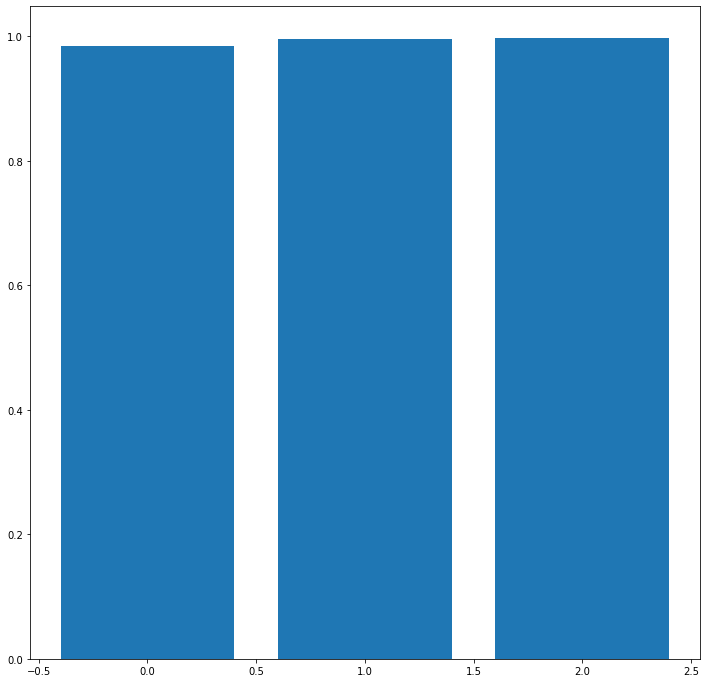

1


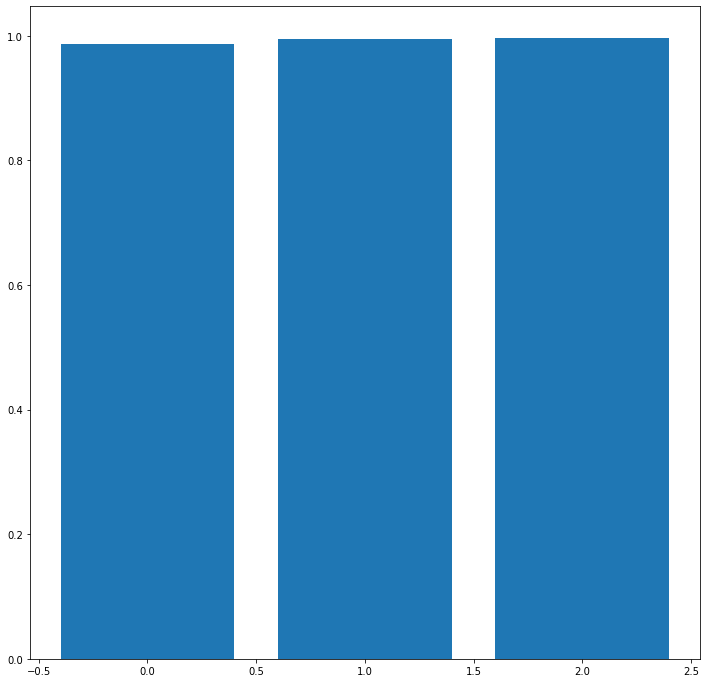

2


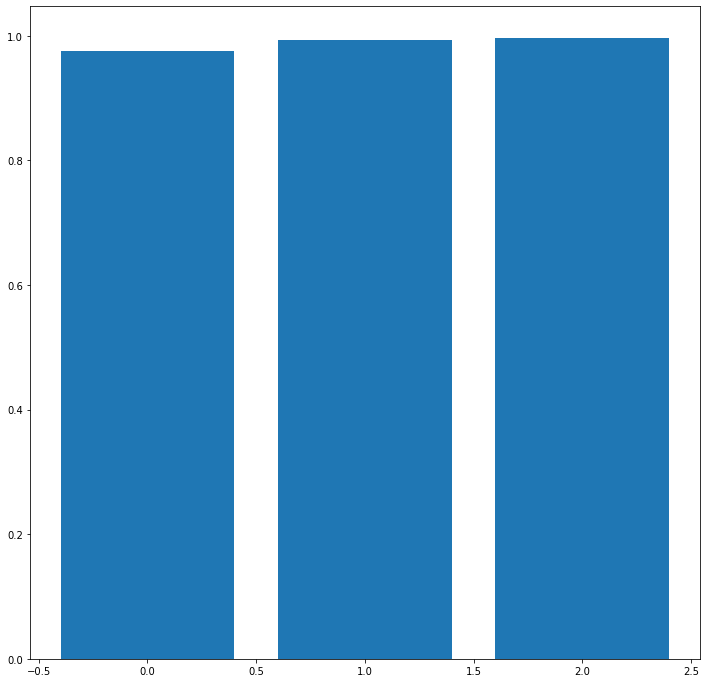

In [47]:
def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture"""
    if len(img.shape) == 3:
        img = rgb2gray(img)
    if len(filtered_img.shape) == 3:
        filtered_img = rgb2gray(filtered_img)
    mu_x = mu(img)
    mu_y = mu(filtered_img)
    sigma_x = qualify_noise(img)
    sigma_y = qualify_noise(filtered_img)
    sig_xy = sigma_xy(img, filtered_img, mu_x, mu_y)
    SSIM = ((2 * mu_x * mu_y) * (2 * sig_xy)) / (((mu_x**2) + (mu_y**2))*((sigma_x**2) + (sigma_y**2) ))
    return SSIM

for i, img in enumerate(images_for_jpeg):
    print(i)
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()